# Classification du Genre et Détection des Émotions des personnes avec ViT(Vision Transformer)

# Classification du Genre avec ViT(Vision Transformer)

## 1. Chargement et Prétraitement du Dataset
#### 1.1 Chargement des Images
Dans cette partie, on charge le dataset Male and Female Faces, précédemment téléchargé depuis Kaggle et enregistré localement sur l’ordinateur. Les images sont réparties en deux classes principales : Male et Female.


In [18]:
import os
# Define dataset paths
men_dir = "content/male_faces"
women_dir = "content/female_faces"

print(f"Nombre d'images hommes: {len(os.listdir(men_dir))}")
print(f"Nombre d'images femmes: {len(os.listdir(women_dir))}")


Nombre d'images hommes: 2721
Nombre d'images femmes: 2699


#### 1.2 Prétraitement des Images
Chaque image est convertie en niveaux de gris, redimensionnée à 48x48 pixels et normalisée dans la plage [0,1] pour s’adapter au modèle ViT.

In [38]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical  # Pour encoder les labels en one-hot

# Paramètre global pour la taille des images
image_size = 48  # Toutes les images seront redimensionnées en 48x48 pixels

def load_and_preprocess_images(men_dir, women_dir, max_images=None):
    """
    Charge et prétraite les images de visages masculins et féminins.
    
    Args:
        men_dir (str): chemin vers le dossier des images masculines
        women_dir (str): chemin vers le dossier des images féminines
        max_images (int, optional): nombre maximum d'images à charger par classe
    
    Returns:
        X (np.array): tableau numpy des images normalisées, shape (num_samples, 48, 48, 1)
        y (np.array): labels one-hot encodés pour Male/Female, shape (num_samples, 2)
    """
    
    X = []  # Liste pour stocker les images
    y = []  # Liste pour stocker les labels

    # --------------------------
    # Traitement des images masculines
    # --------------------------
    male_files = [f for f in os.listdir(men_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]  # Lister les fichiers valides
    if max_images:
        male_files = male_files[:max_images]  # Limiter le nombre d’images si spécifié
    
    for file in male_files:
        img_path = os.path.join(men_dir, file)  # Chemin complet de l'image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris
        if img is None:
            continue  # Ignorer si l'image ne peut pas être lue
        img = cv2.resize(img, (image_size, image_size))  # Redimensionner
        X.append(img)  # Ajouter à la liste des images
        y.append(1)    # Label 1 pour "Male"

    # --------------------------
    # Traitement des images féminines
    # --------------------------
    female_files = [f for f in os.listdir(women_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if max_images:
        female_files = female_files[:max_images]
    
    for file in female_files:
        img_path = os.path.join(women_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(0)  # Label 0 pour "Female"

    # --------------------------
    # Conversion en tableaux numpy
    # --------------------------
    X = np.array(X).reshape(-1, image_size, image_size, 1) / 255.0  # Normaliser les pixels [0,1] et ajouter la dimension canal
    y = to_categorical(np.array(y), num_classes=2)  # One-hot encode pour Male/Female

    return X, y  # Retourne les images et les labels préparés

# --------------------------
# Exemple d'utilisation
# --------------------------
X, y = load_and_preprocess_images(men_dir, women_dir, max_images=2000)
print(f"Dataset loaded: {X.shape}, Labels: {y.shape}")  # Affiche la taille finale du dataset et des labels


Dataset loaded: (4000, 48, 48, 1), Labels: (4000, 2)


## 2. Modèle de Reconnaissance de Genre
#### 2.1 Construction du Modèle ViT (Vision Transformer)
On construit un Vision Transformer (ViT) adapté à la classification binaire (homme/femme).
Le modèle utilise :

- Une division en patches de taille 6x6,

- Un encodeur de patches avec embeddings positionnels,

- Plusieurs couches Transformer avec mécanismes d’attention multi-têtes,

- Une tête de classification (MLP) avec deux neurones en sortie (softmax).

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --------------------------
# Paramètres du modèle
# --------------------------
image_size = 48         # Taille d'entrée des images (48x48 pixels)
patch_size = 6          # Taille des patches extraits de l'image
num_classes = 2         # Nombre de classes pour la classification (Male/Female)
projection_dim = 64     # Dimension des embeddings projetés pour chaque patch
transformer_layers = 8  # Nombre de blocs Transformer
num_heads = 4           # Nombre de têtes pour le Multi-Head Attention
mlp_head_units = [128, 64]  # Unitès pour les couches denses en sortie (classification)

# --------------------------
# Classe pour créer les patches
# --------------------------
class Patches(layers.Layer):
    """
    Cette couche découpe chaque image en patches de taille patch_size x patch_size
    et les convertit en un vecteur pour être traité par le Transformer.
    """
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]  # Nombre d'images dans le batch
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Taille de patch
            strides=[1, self.patch_size, self.patch_size, 1],  # Pas de déplacement
            rates=[1, 1, 1, 1],  # Pas de dilation
            padding="VALID",      # Pas de padding
        )
        patch_dims = patches.shape[-1]  # Dimension de chaque patch aplati
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Reshape pour le Transformer
        return patches

# --------------------------
# Classe pour encoder les patches
# --------------------------
class PatchEncoder(layers.Layer):
    """
    Cette couche projette chaque patch en un vecteur de dimension projection_dim
    et ajoute un embedding de position pour conserver l'ordre spatial.
    """
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)  # Projection linéaire
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim  # Embedding des positions
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # Indices des patches
        encoded = self.projection(patch) + self.position_embedding(positions)  # Ajouter position
        return encoded

# --------------------------
# Fonction pour créer le modèle ViT
# --------------------------
def create_vit_model():
    num_patches = (image_size // patch_size) ** 2  # Nombre total de patches par image

    # Entrée du modèle
    inputs = layers.Input(shape=(image_size, image_size, 1))  # Images grayscale
    patches = Patches(patch_size)(inputs)  # Découpage en patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)  # Encodage + position

    # --------------------------
    # Blocs Transformer
    # --------------------------
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  # Normalisation
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)  # Attention multi-têtes
        x2 = layers.Add()([attention_output, encoded_patches])  # Skip connection
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)  # Normalisation
        x3 = layers.Dense(projection_dim * 2, activation="relu")(x3)  # MLP dans le Transformer
        x3 = layers.Dense(projection_dim, activation="relu")(x3)
        encoded_patches = layers.Add()([x3, x2])  # Skip connection

    # --------------------------
    # Tête de classification
    # --------------------------
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  # Normalisation finale
    representation = layers.Flatten()(representation)  # Aplatir pour le MLP
    for units in mlp_head_units:
        representation = layers.Dense(units, activation="relu")(representation)  # Dense layers
        representation = layers.Dropout(0.5)(representation)  # Dropout pour régularisation
    logits = layers.Dense(num_classes, activation="softmax")(representation)  # Sortie finale (Male/Female)

    # Création du modèle Keras
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# --------------------------
# Instanciation et résumé
# --------------------------
model = create_vit_model()
model.summary()  # Affiche l'architecture complète du modèle


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 patches_4 (Patches)            (None, None, 36)     0           ['input_5[0][0]']                
                                                                                                  
 patch_encoder_4 (PatchEncoder)  (None, 64, 64)      6464        ['patches_4[0][0]']              
                                                                                                  
 layer_normalization_56 (LayerN  (None, 64, 64)      128         ['patch_encoder_4[0][0]']        
 ormalization)                                                                              

#### 2.2 Compilation, Entraînement et Évaluation du Modèle
Le modèle est compilé avec l’optimiseur Adam, la fonction de perte categorical_crossentropy, et la métrique accuracy.
L’entraînement est effectué sur l’ensemble d’apprentissage avec validation sur l’ensemble de test.

In [22]:
from sklearn.model_selection import train_test_split

# --------------------------
# Séparation des données en ensembles d'entraînement et de test
# --------------------------
# X : images prétraitées
# y : labels one-hot (male/female)
# test_size=0.2 : 20% des données pour le test
# random_state=42 : pour reproductibilité
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# Compilation du modèle
# --------------------------
# Optimiseur Adam avec learning_rate de 0.0001
# Fonction de perte categorical_crossentropy pour classification multi-classes (ici 2 classes)
# Metric "accuracy" pour mesurer la précision pendant l'entraînement et la validation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# --------------------------
# Entraînement du modèle
# --------------------------
# X_train, y_train : données d'entraînement
# validation_data=(X_test, y_test) : validation sur l'ensemble de test
# epochs=20 : nombre d'itérations sur tout le dataset
# batch_size=32 : nombre d'échantillons par mise à jour du gradient
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# --------------------------
# Évaluation du modèle sur l'ensemble de test
# --------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")  # Affiche la précision finale sur le test


Epoch 1/20
50/50 [==============================] - 30s 407ms/step - loss: 0.8536 - accuracy: 0.4900 - val_loss: 0.6835 - val_accuracy: 0.5600
Epoch 2/20
50/50 [==============================] - 18s 362ms/step - loss: 0.7046 - accuracy: 0.5200 - val_loss: 0.6840 - val_accuracy: 0.6150
Epoch 3/20
50/50 [==============================] - 18s 366ms/step - loss: 0.6895 - accuracy: 0.5375 - val_loss: 0.6764 - val_accuracy: 0.6500
Epoch 4/20
50/50 [==============================] - 18s 363ms/step - loss: 0.6869 - accuracy: 0.5475 - val_loss: 0.6818 - val_accuracy: 0.6525
Epoch 5/20
50/50 [==============================] - 18s 361ms/step - loss: 0.6888 - accuracy: 0.5256 - val_loss: 0.6736 - val_accuracy: 0.5400
Epoch 6/20
50/50 [==============================] - 19s 384ms/step - loss: 0.6789 - accuracy: 0.5569 - val_loss: 0.6633 - val_accuracy: 0.6250
Epoch 7/20
50/50 [==============================] - 19s 383ms/step - loss: 0.6803 - accuracy: 0.5788 - val_loss: 0.6490 - val_accuracy: 0.6575

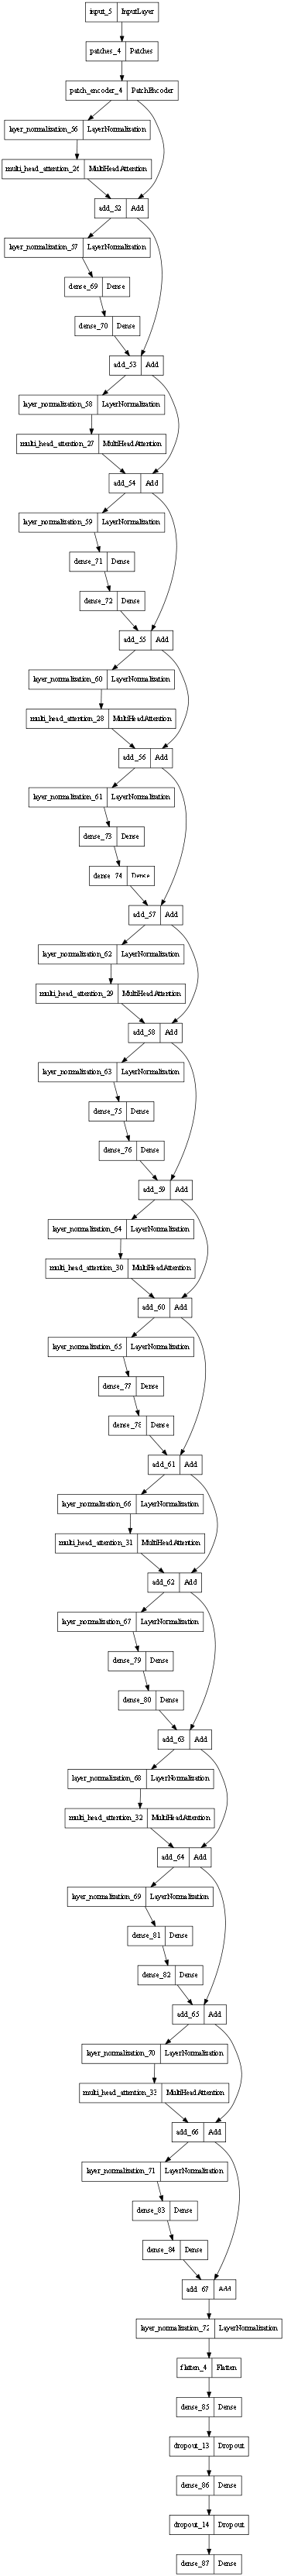

In [35]:
# Visualiser l'architecture du modèle
from tensorflow.keras.utils import plot_model
plot_model(model, dpi=50)
# plot_model : génère un diagramme de l'architecture du modèle
# dpi=50 : résolution de l'image générée

#### 2.3 Tester le Modèle ViT sur une Nouvelle Image
Cette étape permet de prédire le genre d’une nouvelle image à l’aide du modèle ViT entraîné. L’image est chargée, redimensionnée à 48x48 pixels, normalisée, puis passée au modèle pour obtenir la prédiction entre Male et Female.

In [37]:
import cv2
import numpy as np

# --------------------------
# Labels pour la classification de genre
# --------------------------
genders = ["Female", "Male"]  # Correspondance des indices de sortie du modèle

# --------------------------
# Chemin vers l'image à tester
# --------------------------
image_path = "female face.jpg"  # le chemin image

# --------------------------
# Chargement de l'image
# --------------------------
# cv2.IMREAD_GRAYSCALE : lecture en niveaux de gris
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    # Vérifie si l'image a bien été chargée
    print("Erreur : Image introuvable.")
else:
    # --------------------------
    # Prétraitement de l'image
    # --------------------------
    face = cv2.resize(image, (48, 48))  # Redimensionner à 48x48 pixels
    face = face / 255.0                  # Normaliser les pixels entre 0 et 1
    face = face.reshape(1, 48, 48, 1)   # Ajouter dimension batch et canal (forme attendue par le modèle)

    # --------------------------
    # Prédiction du genre
    # --------------------------
    prediction = model.predict(face)                     # Obtenir les probabilités pour chaque classe
    gender = genders[int(np.argmax(prediction))]         # Sélectionner la classe avec la probabilité maximale

    # --------------------------
    # Affichage du résultat
    # --------------------------
    print(f"Le genre prédit est : {gender}")


1/1 [==============================] - 0s 41ms/step
Le genre prédit est : Female


# Détection des Émotions avec ViT(Vision Transformer)
##  Description:
Description :
Dans ce projet, nous avons utilisé :

- Le dataset CK+ (Cohn-Kanade Extended), qui contient des images faciales annotées avec sept émotions principales : colère, mépris, dégoût, peur, joie, tristesse et surprise.

- Un modèle basé sur les Transformers, plus précisément un Vision Transformer (ViT), pour classer les expressions faciales à partir d’images prétraitées.

## Le pipeline suivi est le suivant :

- Prétraitement des images : détection et alignement des visages, redimensionnement à 48x48 pixels et normalisation.

- Construction du modèle ViT : extraction des patches, encodage positionnel, couches de transformer et un classifieur dense.

- Entraînement : le modèle a été entraîné avec des techniques d’augmentation de données (rotations, translations, flips horizontaux) pour améliorer la robustesse.

- Évaluation et test : après l’entraînement, le modèle a été testé sur de nouvelles images pour prédire l’émotion affichée.


## 1. Charger et Explorer CK+
#### 1.1 Vérifier la Structure des Dossiers

Les images sont stockées dans des dossiers nommés d'après les émotions (anger, contempt, disgust, fear, happy, sadness, surprise). On va :

-Lister les classes disponibles.

-Compter le nombre d'images par classe.

-Afficher quelques images pour visualiser les données.

Classes d'émotions : ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
anger: 135 images
contempt: 54 images
disgust: 177 images
fear: 75 images
happy: 207 images
sadness: 84 images
surprise: 249 images


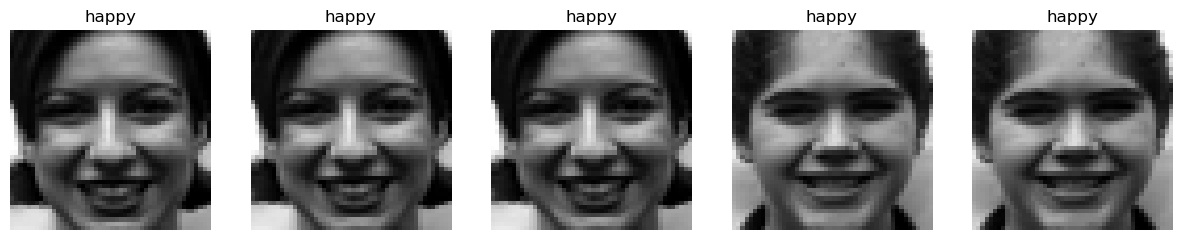

In [25]:
import os
import cv2
import matplotlib.pyplot as plt

# --------------------------
# Chemin vers le dataset CK+
# --------------------------
dataset_path = r"C:\Users\khadija\Desktop\Image processing project\Modele CNN\emotions"

# Vérifie si le chemin existe
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Le chemin du dataset {dataset_path} n'existe pas. Vérifiez le chemin.")

# --------------------------
# Lister les classes d'émotions
# --------------------------
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes d'émotions :", classes)

# --------------------------
# Compter le nombre d'images par classe
# --------------------------
for emotion in classes:
    path = os.path.join(dataset_path, emotion)
    images = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"{emotion}: {len(images)} images")

# --------------------------
# Fonction pour afficher des exemples d'images
# --------------------------
def show_sample_images(emotion, num_images=5):
    """Affiche un échantillon d'images pour une émotion donnée."""
    emotion_path = os.path.join(dataset_path, emotion)
    if not os.path.exists(emotion_path):
        print(f"Aucun dossier trouvé pour l'émotion {emotion}")
        return
    # Sélectionner les premières 'num_images' images
    images = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:num_images]
    if not images:
        print(f"Aucune image trouvée dans {emotion_path}")
        return
    # Créer la figure pour afficher les images
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    if len(images) == 1:
        axes = [axes]  # Pour gérer le cas d'une seule image
    for i, img_name in enumerate(images):
        img_path = os.path.join(emotion_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Lecture en niveaux de gris
        if img is None:
            print(f"Erreur lors du chargement de l'image : {img_path}")
            continue
        axes[i].imshow(img, cmap='gray')  # Affichage de l'image
        axes[i].set_title(emotion)        # Titre avec le nom de l'émotion
        axes[i].axis('off')               # Masquer les axes
    plt.show()

# --------------------------
# Exemple : afficher quelques images de l'émotion "happy"
# --------------------------
show_sample_images("happy")


## 2. Prétraitement des Images
#### 2.1 Détecter, Aligner et Normaliser les Visages
Cette section initialise les détecteurs de visages et yeux, puis pour chaque image :

- Détecte le visage.

- Si deux yeux sont détectés, aligne le visage.

In [26]:
import cv2
import numpy as np

# --------------------------
# Initialiser les classificateurs Haar Cascade pour visage et yeux
# --------------------------
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# --------------------------
# Fonction pour détecter et aligner un visage dans une image
# --------------------------
def detect_and_align_face(img_path):
    """
    Charge une image, détecte le visage et aligne le visage si deux yeux sont détectés.
    
    Args:
        img_path (str): Chemin vers l'image.
    
    Returns:
        face (ndarray): Image du visage aligné (ou original si aucun visage détecté).
    """
    # Charger l'image en niveaux de gris
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erreur lors du chargement de l'image : {img_path}")
        return None
    
    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    
    if len(faces) > 0:
        # Prendre le premier visage détecté
        (x, y, w, h) = faces[0]
        face = img[y:y+h, x:x+w]
        
        # Détecter les yeux dans le visage
        eyes = eye_cascade.detectMultiScale(face, scaleFactor=1.1, minNeighbors=5)
        
        if len(eyes) >= 2:
            # Prendre les deux premiers yeux détectés
            (ex1, ey1, ew1, eh1), (ex2, ey2, ew2, eh2) = eyes[:2]
            # Calculer le centre entre les deux yeux
            eye_center = ((ex1 + ex2 + ew1 + ew2) / 2, (ey1 + ey2 + eh1 + eh2) / 2)
            # Calculer la différence entre les yeux
            dx, dy = ex2 - ex1, ey2 - ey1
            # Calculer l'angle d'orientation
            angle = np.degrees(np.arctan2(dy, dx))
            # Créer la matrice de rotation
            M = cv2.getRotationMatrix2D(eye_center, angle, 1)
            # Appliquer la rotation pour aligner le visage
            face = cv2.warpAffine(face, M, (face.shape[1], face.shape[0]))
        
        return face
    else:
        # Retourner l'image originale si aucun visage détecté
        return img


#### 2.2 Redimensionner et Normaliser pour ViT
Cette section prend l’image détectée et alignée puis :

- Redimensionne à 48x48 pixels pour le modèle ViT.

- Normalise les pixels dans la plage [0, 1].

In [27]:
def resize_and_normalize(face_img):
    """
    Redimensionne une image de visage à 48x48 pixels et normalise les pixels dans [0,1].
    
    Args:
        face_img (ndarray): Image du visage (grayscale).
    
    Returns:
        face_normalized (ndarray): Image redimensionnée et normalisée, ou None si l'image est vide.
    """
    
    # Vérifier si l'image est valide
    if face_img is None:
        return None
    
    # Redimensionner l'image à 48x48 pixels (taille d'entrée du modèle ViT)
    face_resized = cv2.resize(face_img, (48, 48))
    
    # Normaliser les pixels pour qu'ils soient compris entre 0 et 1
    face_normalized = face_resized / 255.0
    
    return face_normalized


# 1.3 Chargement et Préparation du Dataset
On charge toutes les images prétraitées du dataset, on crée les labels numériques correspondants, et les données sont prêtes pour l’entraînement. 

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

# Listes pour stocker les images et les labels
X = []
y = []

# Mapping des émotions vers des indices
label_map = {emotion: idx for idx, emotion in enumerate(classes)}

# Parcourir chaque classe d'émotion
for emotion in classes:
    folder_path = os.path.join(dataset_path, emotion)  # chemin du dossier de l'émotion
    if not os.path.exists(folder_path):
        print(f"Dossier non trouvé : {folder_path}")
        continue

    # Parcourir toutes les images du dossier
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # Détecter et aligner le visage avec la fonction définie précédemment
        face = detect_and_align_face(img_path)
        
        # Redimensionner à 48x48 et normaliser les pixels
        face = resize_and_normalize(face)
        
        # Ajouter uniquement si le visage a été correctement détecté
        if face is not None:
            X.append(face)
            y.append(label_map[emotion])

# Convertir les listes en arrays numpy et ajouter la dimension du canal (grayscale)
X = np.array(X).reshape(-1, 48, 48, 1)
y = np.array(y)


## 3- Modèles de reconnaissance des expressions faciale
#### 3.1- Construction du Modèle ViT (Vision Transformer) pour la Classification des Expressions Faciales
Description :
Cette section définit un modèle ViT pour reconnaître les expressions faciales. Chaque image est découpée en patchs, encodée avec des embeddings de position, puis traitée par plusieurs blocs transformer avant d’être classée par un MLP.

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Paramètres du modèle ViT
# =========================
image_size = 48           # Taille des images d'entrée (48x48 pixels)
patch_size = 6            # Taille de chaque patch
num_patches = (image_size // patch_size) ** 2  # Nombre total de patches par image
projection_dim = 64       # Dimension dans laquelle chaque patch sera projeté
num_heads = 4             # Nombre de têtes dans l'attention multi-head
transformer_layers = 8    # Nombre de blocs transformer
mlp_head_units = [128, 64]  # Neurones dans les couches Dense après les transformers
num_classes = 7           # Nombre de classes d'émotions dans CK+ dataset
input_shape = (48, 48, 1)  # Forme des images d'entrée (grayscale)

# =================================
# Couche pour diviser l'image en patches
# =================================
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        """
        Divise chaque image en patches non chevauchants.
        images: tensor de forme (batch_size, height, width, channels)
        retourne: tensor de forme (batch_size, num_patches, patch_dims)
        """
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Taille du patch
            strides=[1, self.patch_size, self.patch_size, 1],  # Pas entre patches
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]  # Dimensions d'un patch aplati
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Flatten
        return patches

# =================================
# Couche pour encoder les patches
# =================================
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)  # Projection linéaire
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )  # Embedding positionnel

    def call(self, patch):
        """
        Encode les patches en ajoutant position embedding.
        """
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# =================================
# Fonction pour créer le modèle ViT
# =================================
def create_vit_model():
    inputs = layers.Input(shape=input_shape)           # Input layer
    patches = Patches(patch_size)(inputs)             # Découper en patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)  # Encoder les patches

    # ==============================
    # Blocs Transformer
    # ==============================
    for _ in range(transformer_layers):
        # Normalisation avant attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Attention multi-head
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # MLP block avec skip connection
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(projection_dim * 2, activation="relu")(x3)
        x3 = layers.Dense(projection_dim, activation="relu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    # ==============================
    # Head de classification
    # ==============================
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)  # Aplatir pour Dense layers
    for units in mlp_head_units:
        representation = layers.Dense(units, activation="relu")(representation)
        representation = layers.Dropout(0.5)(representation)
    logits = layers.Dense(num_classes, activation="softmax")(representation)

    # Création du modèle final
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# =================================
# Créer et afficher le modèle
# =================================
model = create_vit_model()
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 patches_3 (Patches)            (None, None, 36)     0           ['input_4[0][0]']                
                                                                                                  
 patch_encoder_3 (PatchEncoder)  (None, 64, 64)      6464        ['patches_3[0][0]']              
                                                                                                  
 layer_normalization_39 (LayerN  (None, 64, 64)      128         ['patch_encoder_3[0][0]']        
 ormalization)                                                                              

#### 3.2- Entraînement du Modèle ViT avec Augmentation de Données

Les données sont divisées en train/test. Pour améliorer la généralisation, on applique une augmentation de données et on entraîne le modèle sur les ensembles d’entraînement, en validant sur l’ensemble de test.

In [31]:
from sklearn.model_selection import train_test_split

# ==============================================
# Diviser les données en ensembles d'entraînement et de test
# stratify=y permet de conserver la proportion des classes dans train et test
# test_size=0.2 signifie 20% pour le test et 80% pour l'entraînement
# random_state=42 pour la reproductibilité
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================================
# Compiler le modèle ViT
# ==============================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Optimiseur Adam avec learning rate faible
    loss="sparse_categorical_crossentropy",  # Utilisé pour labels entiers (0 à 6)
    metrics=["accuracy"]                      # Métrique principale : accuracy
)

# ==============================================
# Entraîner le modèle
# history stocke l'évolution des métriques pour tracer plus tard si besoin
# ==============================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Valider sur l'ensemble de test à chaque epoch
    epochs=30,                          # Nombre d'epochs
    batch_size=32,                      # Taille du batch
    verbose=1                            # Affiche la progression de l'entraînement
)

# ==============================================
# Évaluer le modèle sur l'ensemble de test
# ==============================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/30
25/25 [==============================] - 24s 439ms/step - loss: 2.2266 - accuracy: 0.1786 - val_loss: 1.8216 - val_accuracy: 0.3350
Epoch 2/30
25/25 [==============================] - 9s 360ms/step - loss: 1.9161 - accuracy: 0.2296 - val_loss: 1.8209 - val_accuracy: 0.2690
Epoch 3/30
25/25 [==============================] - 9s 374ms/step - loss: 1.8935 - accuracy: 0.2258 - val_loss: 1.8703 - val_accuracy: 0.2538
Epoch 4/30
25/25 [==============================] - 9s 354ms/step - loss: 1.8805 - accuracy: 0.2258 - val_loss: 1.8309 - val_accuracy: 0.2538
Epoch 5/30
25/25 [==============================] - 10s 385ms/step - loss: 1.8702 - accuracy: 0.2385 - val_loss: 1.8330 - val_accuracy: 0.2640
Epoch 6/30
25/25 [==============================] - 9s 345ms/step - loss: 1.8355 - accuracy: 0.2487 - val_loss: 1.7452 - val_accuracy: 0.2640
Epoch 7/30
25/25 [==============================] - 10s 395ms/step - loss: 1.8520 - accuracy: 0.2615 - val_loss: 1.7275 - val_accuracy: 0.3858
Epo

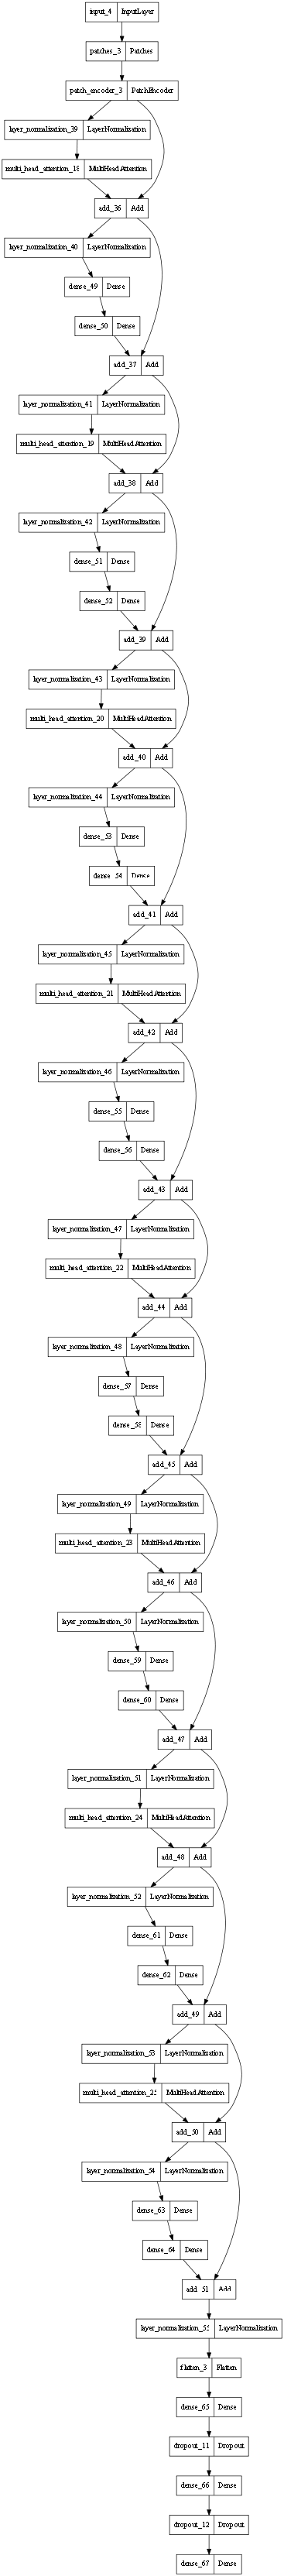

In [32]:
# Visualiser l'architecture du modèle
from tensorflow.keras.utils import plot_model
plot_model(model, dpi=50)

#### 3.3- Tester le Modèle ViT sur une Nouvelle Image
Description :
Cette section permet de tester le modèle ViT sur une nouvelle image en :

- Détectant et alignant le visage.

- Redimensionnant et normalisant l’image.

- Prédire l’émotion avec le modèle entraîné.

In [16]:
import cv2
import numpy as np

# Liste des émotions correspondant aux labels
emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

# Chemin vers l'image à tester
image_path = "Happy_face.png"  # Remplacer par le chemin de votre image

# Charger l'image et vérifier si elle existe
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Erreur : Image introuvable.")
else:
    # Prétraitement : Détecter et aligner le visage
    face = detect_and_align_face(image_path)
    
    # Redimensionner et normaliser
    face = resize_and_normalize(face)
    
    # Ajouter la dimension batch
    face = face.reshape(1, 48, 48, 1)
    
    # Prédire l'émotion
    prediction = model.predict(face)
    emotion = emotions[int(np.argmax(prediction))]
    
    print(f"L'émotion prédite est : {emotion}")


1/1 [==============================] - 0s 77ms/step
L'émotion prédite est : anger
